## Implementation of the cross-entropy-method of policy optimization.

In [1]:
import gym
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd


In [2]:
from collections import deque

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent(nn.Module):
    
    
    def __init__(self,env,h_size = 16):
        
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
               
        self.fc1 = nn.Linear(self.s_size,self.h_size)
        self.fc2 = nn.Linear(self.h_size,self.a_size)
        
        
        
    def weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
    
    
    def evaluate(self,weights,gamma = 1.0,max_t = 5000):
        ## get weights for the nn, run it and output reward
        self.set_weights(weights)
        state = env.reset()
        episode_return = 0
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            next_state,reward,done,_ = env.step(action)
            state = next_state
            episode_return +=reward * math.pow(gamma,t)
            
            if done:
                break
                
        return episode_return
    
    
    
    
    def set_weights(self, weights):
        
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        fc1_end = (s_size*h_size )+ h_size
        
        fc1_W = torch.from_numpy(weights[:s_size*h_size]).reshape(s_size,h_size)
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:(fc1_end)+(h_size*a_size)]).reshape(h_size,a_size)
        fc2_b = torch.from_numpy(weights[(fc1_end)+(h_size*a_size):])
        
        #set_weights
        
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
        
    
            
    
        
        
        
        
        
    

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation space: Box(2,)
action space: Box(1,)
  - low: [-1.]
  - high: [1.]


In [4]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    
    """
    pop_size: total noised policies to generate each iteration.
    
    
    """
    top_pols = int(elite_frac * pop_size) ## using top 20% policies for next policy
    scores_deque= deque(maxlen = 100)
    scores = []
    score = 0
    
    best_weight = sigma*np.random.randn(agent.weights_dim())# get initial random weights from normal distribution
    
    
    for i_iteration in range(1,n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weight,gamma,max_t) for weight in weights_pop])
        
        
        top_pols_idx = rewards.argsort()[-top_pols:] 
        # argsort returns an array with only indices corresponding to sorted 
        #rewards. Indices won't be sorted. just indices of sorted rewards array are returned.
        
        # get corresponding weights
        top_weights = [weights_pop[i] for i in top_pols_idx]
        # get average of the  weights
        best_weight = np.array(top_weights).mean(axis=0)
        reward = agent.evaluate(best_weight,gamma,max_t)
        
        scores.append(reward)
        scores_deque.append(reward)
        
        
        torch.save(agent.state_dict(), 'checkpoint_mine.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores



        
    
    
    
    
    
    
    
    
    

In [5]:
agent = Agent(env).to(device)

In [6]:
scores = cem()



C:\Users\Akshay\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: -1.44
Episode 20	Average Score: -3.98
Episode 30	Average Score: -4.18
Episode 40	Average Score: 2.57
Episode 50	Average Score: 18.74
Episode 60	Average Score: 29.35
Episode 70	Average Score: 38.69
Episode 80	Average Score: 45.65
Episode 90	Average Score: 47.98
Episode 100	Average Score: 52.56
Episode 110	Average Score: 62.09
Episode 120	Average Score: 72.28
Episode 130	Average Score: 82.21
Episode 140	Average Score: 89.48

Environment solved in 47 iterations!	Average Score: 90.83


Text(0,0.5,'Scores')

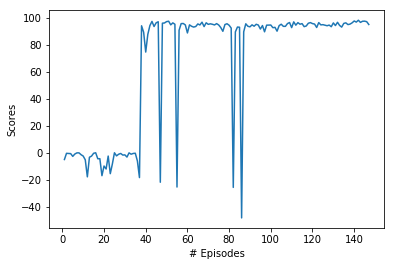

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.add_subplot(111)
plt.plot(range(1,len(scores)+1),scores)
plt.xlabel("# Episodes")
plt.ylabel("Scores")
